## MCX simulation Stage 1

In [5]:
! pip install pmcx
! pip install numpy pmcx jdata bjdata matplotlib

In [6]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
import pmcx

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
folder_path = '/content/drive/MyDrive/MCX_data'
if folder_path not in sys.path:
    sys.path.append(folder_path)
from FD_msNIRS import mcx_simulation as ms

In [8]:
pmcx.gpuinfo()

[{'name': 'NVIDIA A100-SXM4-40GB',
  'id': 1,
  'devcount': 1,
  'major': 8,
  'minor': 0,
  'globalmem': 42474471424,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1410000,
  'sm': 108,
  'core': 6912,
  'autoblock': 64,
  'autothread': 442368,
  'maxgate': 0}]

### MCX Simulation using packgae

In [9]:
import pmcx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
from FD_msNIRS import mcx_fft as mf
from FD_msNIRS import extract_freq as ef

In [10]:
g=0.85
ua = 0.2  # cm-1
us_prime = 15 # cm-1
us = us_prime/(1-g)
distance = [2, 2.5, 3, 3.5] # cm

In [11]:
us

99.99999999999999

In [12]:
# compute ua, distance, and us in mm-1
ua_mm = ua/10
us_mm = us/10
distance_mm = [d*10 for d in distance]

In [13]:
ua_mm

0.02

In [14]:
us_mm

9.999999999999998

### Run simulations

In [15]:
dictt_ms = {}
for i in range(0, len(distance_mm)):
  d = distance_mm[i]
  print('distance (mm) = ', d)
  TPSF, time_unit = ms(ua_mm, us_mm, g=0.85, n=1.370, distance = d, tend =1e-08, devf = 1000, nphoton = 1.2e8)
  dictt_ms[d] = [TPSF, time_unit]

distance (mm) =  20
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
distance (mm) =  25.0
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
distance (mm) =  30
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
distance (mm) =  35.0
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1


In [16]:
target_freq = 110e6
uac = np.zeros_like(distance_mm) # empty array
udc = np.zeros_like(distance_mm) # empty array
phase1 = np.zeros_like(distance_mm) # empty array
phase2 = np.zeros_like(distance_mm) # empty array

# four loops:
i=0
for k, v in dictt_ms.items():
  TPSF, tstep = v
  uac[i], udc[i], phase1[i] , phase2[i]= ef(target_freq, TPSF, tend=1e-08, devf=1000)
  i = i+1

In [17]:
udc[0]

np.float64(6.765869523387094e-06)

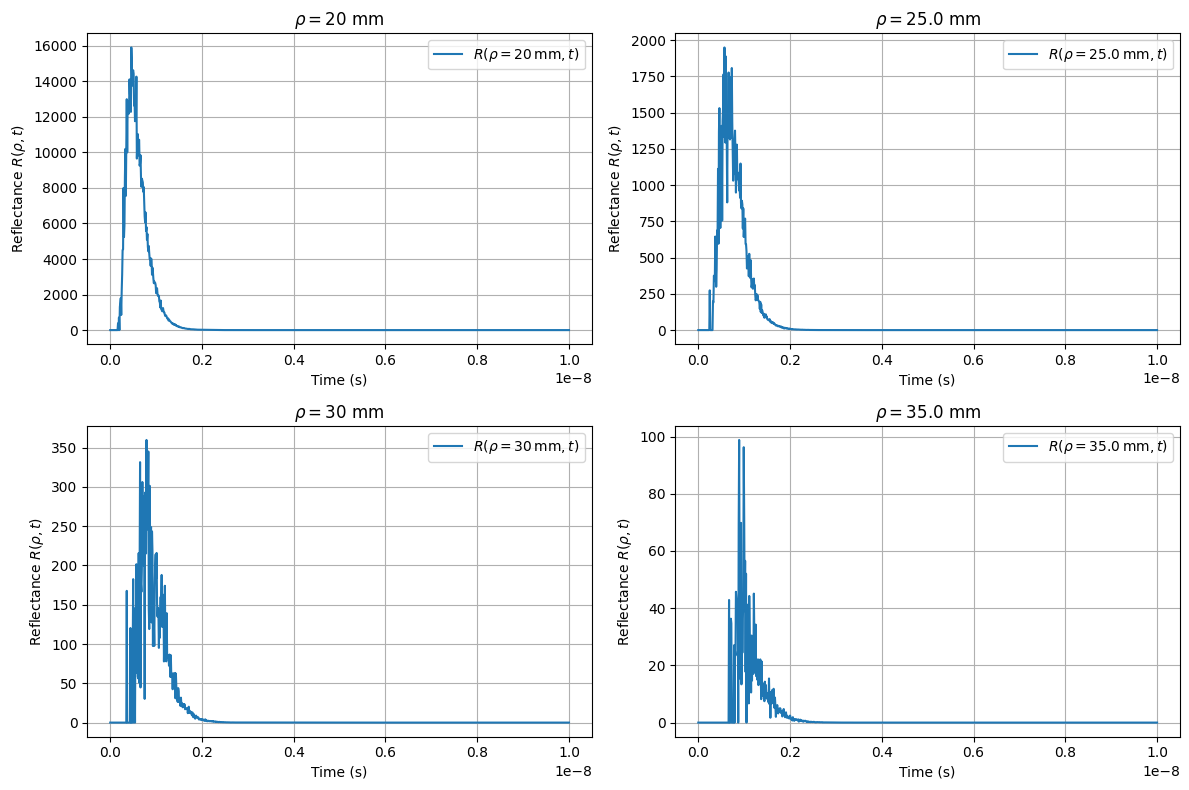

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()  # Flatten to access axs[0] to axs[3]

# Loop through and plot each one
for i, d in enumerate(distance_mm):
    signal, dt = dictt_ms[d]
    times = np.linspace(0, len(signal) * dt, len(signal))
    axs[i].plot(times, signal, label=fr"$R(\rho={d}\,\mathrm{{mm}}, t)$")
    axs[i].set_title(fr"$\rho = {d}$ mm")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel(r"Reflectance $R(\rho, t)$")
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

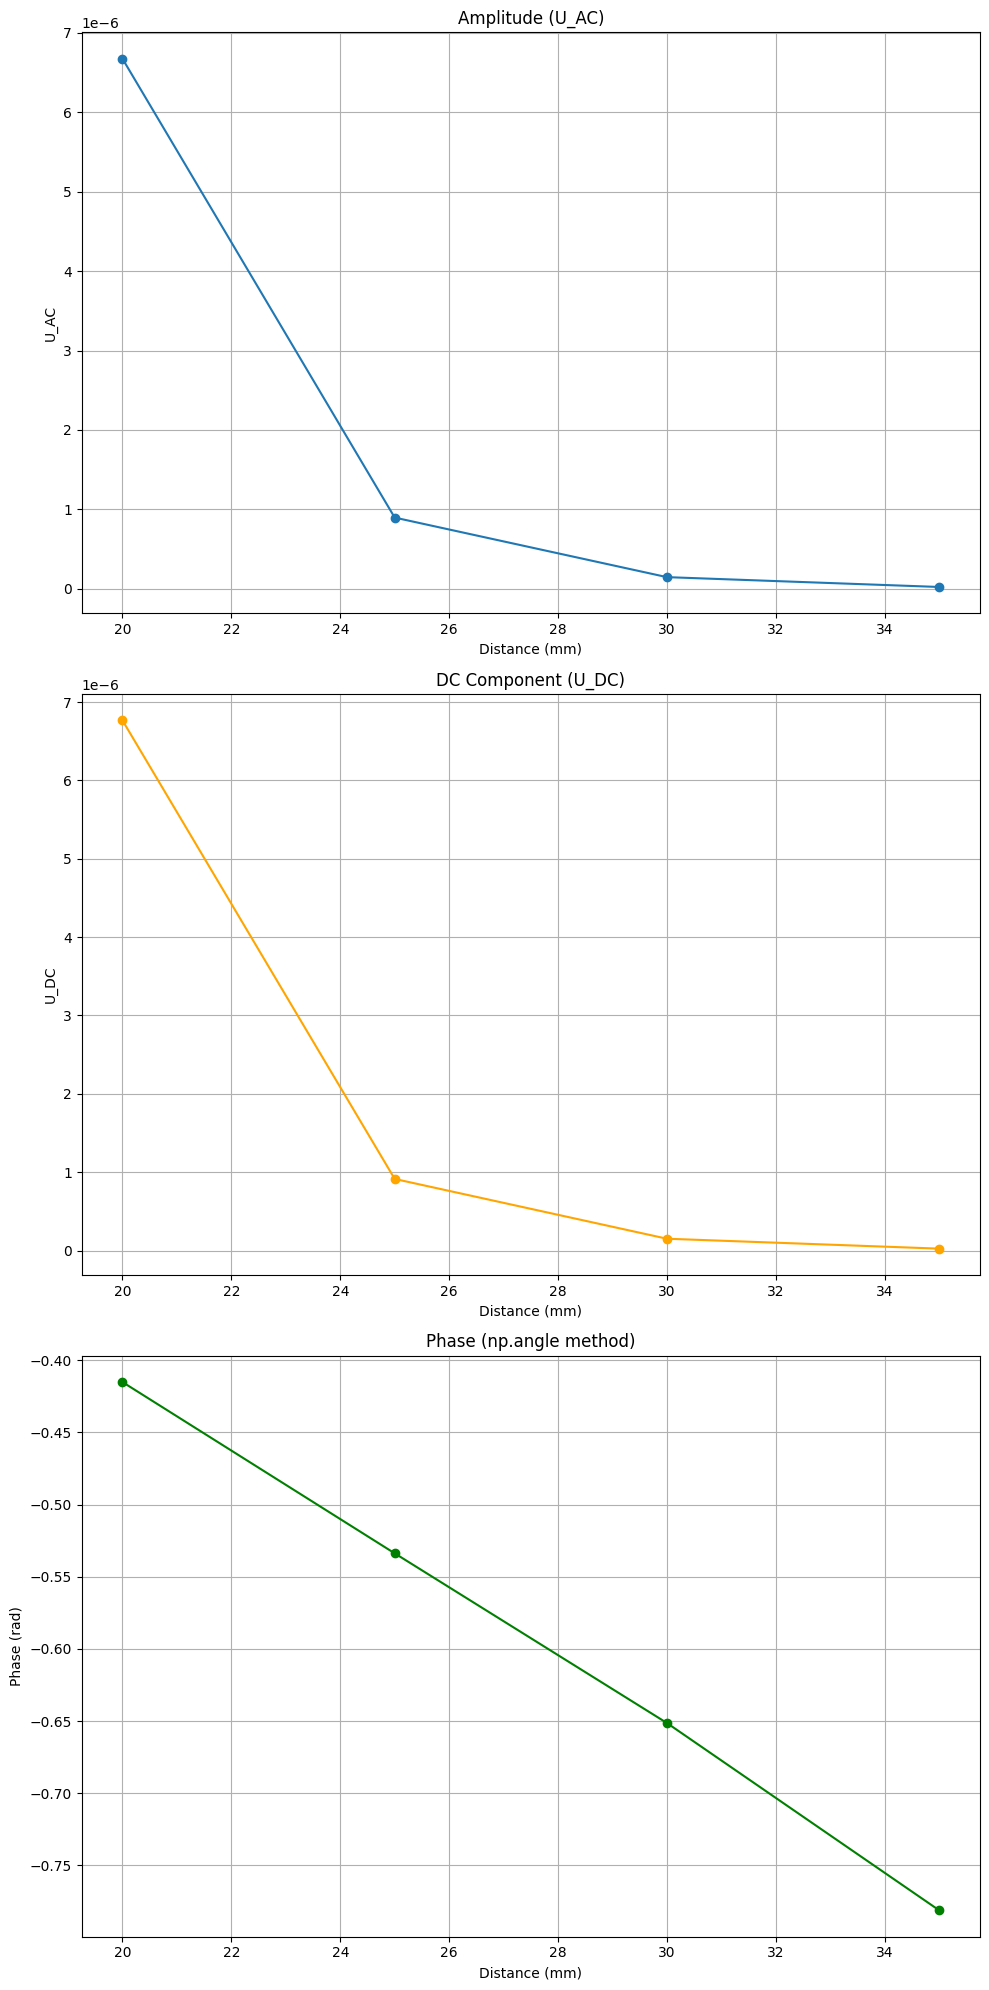

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Create 3 vertically stacked subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 20))

# Subplot 1: UAC vs distance
axs[0].plot(distance_mm, uac, 'o-', label='U_AC')
axs[0].set_title("Amplitude (U_AC)")
axs[0].set_xlabel("Distance (mm)")
axs[0].set_ylabel("U_AC")
axs[0].grid(True)

# Subplot 2: UDC vs distance
axs[1].plot(distance_mm, udc, 'o-', label='U_DC', color='orange')
axs[1].set_title("DC Component (U_DC)")
axs[1].set_xlabel("Distance (mm)")
axs[1].set_ylabel("U_DC")
axs[1].grid(True)

# Subplot 3: Phase1 vs distance
axs[2].plot(distance_mm, phase1, 'o-', label='Phase (np.angle)', color='green')
axs[2].set_title("Phase (np.angle method)")
axs[2].set_xlabel("Distance (mm)")
axs[2].set_ylabel("Phase (rad)")
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [20]:
# Prepare column headers and row data
import pandas as pd
columns = []
row = []

for i in range(len(uac)):
    columns.extend([
        f"U_AC_{i+1}_1",
        f"U_DC_{i+1}_1",
        f"Phase_{i+1}_1"
    ])
    row.extend([uac[i], udc[i], phase1[i]])

# Create DataFrame and export
df = pd.DataFrame([row], columns=columns)
df.to_csv("stage1_laser.csv", index=False)

In [21]:
phase2

array([-0.41610588, -0.53513151, -0.65294121, -0.78329982])

In [22]:
phase1

array([-0.41509479, -0.53377622, -0.65136653, -0.78116238])